In [3]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
import ast
from sklearn.metrics import brier_score_loss
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer

In [4]:
datasets = []
for i in range(1, 11):
    df = pd.read_csv(f'../train/{i:05d}/train_stage1.csv')
    df['target_vector'] = df['target_vector'].apply(ast.literal_eval) 
    
    def set_max_to_one(target_list):
        max_value = max(target_list)
        return [1 if value == max_value else 0 for value in target_list]
    
    target_df = pd.DataFrame(df['target_vector'].apply(set_max_to_one).tolist(), index=df.index)
    features_df = df.drop(columns=['target_vector'])
    datasets.append((features_df, target_df))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

brier_scores = []
model_importance1 = []

for train_index, test_index in kf.split(datasets):
    X_train = pd.concat([datasets[i][0] for i in train_index], ignore_index=True)
    y_train = pd.concat([datasets[i][1] for i in train_index], ignore_index=True)
    
    X_test = pd.concat([datasets[i][0] for i in test_index], ignore_index=True)
    y_test = pd.concat([datasets[i][1] for i in test_index], ignore_index=True)
    

    model = make_pipeline(
        SimpleImputer(strategy='constant', fill_value=0),  
        MultiOutputClassifier(DecisionTreeClassifier())
    )
    
    model.fit(X_train, y_train)

    model_classifier = model.named_steps['multioutputclassifier']

    model_importance1.append(estimator.feature_importances_ for estimator in model_classifier.estimators_)
    
   
    y_prob = model.predict_proba(X_test)
    
    brier_score = np.mean([brier_score_loss(y_test.iloc[:, c], y_prob[c][:, 1], pos_label=1) for c in range(y_test.shape[1])])
    brier_scores.append(brier_score)
    print(brier_score)

print(f'Stage 1 Average score across all folds: {np.mean(brier_scores)}')

0.07894547028274669
0.08103516868236792
0.07120248193528118
0.07361663099969427
0.07004848783694936
Stage 1 Average score across all folds: 0.07496964794740787


In [5]:
importance_df1 = pd.DataFrame()

features1 = pd.read_csv('../train/00001/train_stage1.csv').drop('target_vector', axis=1).columns

importance_df1['features'] = features1

counter = 1
for generator in model_importance1:
    for value in generator:
        col_name = 'value' + str(counter)
        importance_df1[col_name] = value
        counter += 1

importance_df1['mean'] = importance_df1.drop('features', axis=1).mean(axis=1)
importance_df1 = importance_df1.sort_values(by='mean')
importance_df1

C:\Users\jhao3\AppData\Local\Temp\ipykernel_6392\918625830.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  importance_df1[col_name] = value
C:\Users\jhao3\AppData\Local\Temp\ipykernel_6392\918625830.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  importance_df1['mean'] = importance_df1.drop('features', axis=1).mean(axis=1)


,features,value1,value2,value3,value4,value5,value6,value7,value8,value9,...,value92,value93,value94,value95,value96,value97,value98,value99,value100,mean
2,location_idx,0.216165,0.071470,0.060989,0.036368,0.077625,0.084659,0.035642,0.066501,0.089604,...,0.053928,0.009979,0.034813,0.021592,0.045324,0.033588,0.031271,0.046558,0.035824,0.061992
0,start,0.180709,0.212922,0.031557,0.246455,0.149537,0.161998,0.144785,0.132703,0.134680,...,0.096654,0.141908,0.164428,0.112955,0.121494,0.176429,0.117080,0.133743,0.150735,0.152445
1,end,0.075627,0.187292,0.160196,0.228559,0.181272,0.134109,0.117313,0.119790,0.266976,...,0.161756,0.135881,0.104282,0.102899,0.110968,0.177159,0.181580,0.179956,0.137636,0.155678
4,y_mean,0.140656,0.235245,0.233894,0.112201,0.193214,0.187703,0.230353,0.175792,0.161864,...,0.196056,0.241326,0.277077,0.275489,0.218051,0.208979,0.185757,0.205848,0.217552,0.205516
5,z_mean,0.143716,0.102434,0.147254,0.192928,0.183160,0.200282,0.237547,0.298247,0.162302,...,0.278886,0.195401,0.186366,0.234342,0.279833,0.251020,0.294048,0.222759,0.220186,0.211691
3,x_mean,0.243128,0.190637,0.366109,0.183488,0.215192,0.231250,0.234359,0.206967,0.184573,...,0.212721,0.275504,0.233033,0.252723,0.224330,0.152825,0.190265,0.211135,0.238067,0.212678


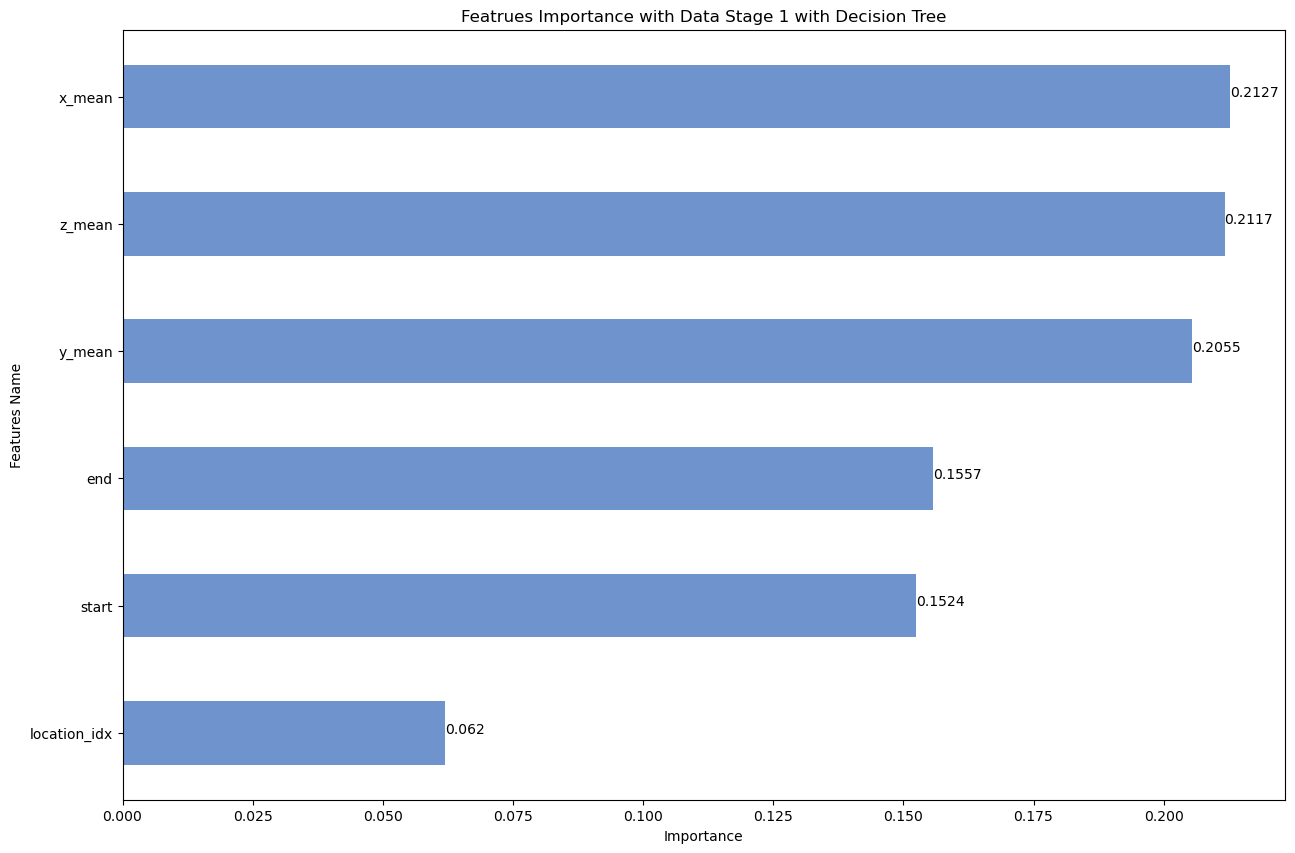

In [6]:
import matplotlib.pyplot as plt

fig, ax1 = plt.subplots(figsize=(15,10))

ax1.barh(importance_df1['features'].tail(10), importance_df1['mean'].tail(10), color='#6f94cd', height=0.5)
ax1.set_ylabel('Features Name')
ax1.set_xlabel('Importance')
ax1.set_title('Featrues Importance with Data Stage 1 with Decision Tree')

for index, value in enumerate(importance_df1['mean'].tail(10)):
    ax1.text(value, index, str(round(value, ndigits=4)))

plt.show()

In [7]:
datasets = []
for i in range(1, 11):
    df = pd.read_csv(f'../train/{i:05d}/train_stage2.csv')
    df['target_vector'] = df['target_vector'].apply(ast.literal_eval) 
    
    def set_max_to_one(target_list):
        max_value = max(target_list)
        return [1 if value == max_value else 0 for value in target_list]
    
    target_df = pd.DataFrame(df['target_vector'].apply(set_max_to_one).tolist(), index=df.index)
    features_df = df.drop(columns=['target_vector'])
    datasets.append((features_df, target_df))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

brier_scores = []
model_importance2 = []

for train_index, test_index in kf.split(datasets):
    X_train = pd.concat([datasets[i][0] for i in train_index], ignore_index=True)
    y_train = pd.concat([datasets[i][1] for i in train_index], ignore_index=True)
    
    X_test = pd.concat([datasets[i][0] for i in test_index], ignore_index=True)
    y_test = pd.concat([datasets[i][1] for i in test_index], ignore_index=True)
    

    model = make_pipeline(
        SimpleImputer(strategy='constant', fill_value=0),  
        MultiOutputClassifier(DecisionTreeClassifier())
    )
    
    model.fit(X_train, y_train)

    model_classifier = model.named_steps['multioutputclassifier']

    model_importance2.append(estimator.feature_importances_ for estimator in model_classifier.estimators_)
    
   
    y_prob = model.predict_proba(X_test)
    
    brier_score = np.mean([brier_score_loss(y_test.iloc[:, c], y_prob[c][:, 1], pos_label=1) for c in range(y_test.shape[1])])
    brier_scores.append(brier_score)
    print(brier_score)

print(f'Stage 2 Average score across all folds: {np.mean(brier_scores)}')

0.06984997114829775
0.06183959261616806
0.0617813383600377
0.05888107612350964
0.05253122945430637
Stage 2 Average score across all folds: 0.06097664154046391


In [8]:
importance_df2 = pd.DataFrame()

features2 = pd.read_csv('../train/00001/train_stage2.csv').drop('target_vector', axis=1).columns

importance_df2['features'] = features2

counter = 1
for generator in model_importance2:
    for value in generator:
        col_name = 'value' + str(counter)
        importance_df2[col_name] = value
        counter += 1

importance_df2['mean'] = importance_df2.drop('features', axis=1).mean(axis=1)
importance_df2 = importance_df2.sort_values(by='mean')
importance_df2

C:\Users\jhao3\AppData\Local\Temp\ipykernel_6392\758550966.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  importance_df2[col_name] = value
C:\Users\jhao3\AppData\Local\Temp\ipykernel_6392\758550966.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  importance_df2['mean'] = importance_df2.drop('features', axis=1).mean(axis=1)


,features,value1,value2,value3,value4,value5,value6,value7,value8,value9,...,value92,value93,value94,value95,value96,value97,value98,value99,value100,mean
23,3d_shape_mean_depth,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000384,...,0.003336,0.000000,0.000000,0.000000,0.004344,0.000000,0.000000,0.000000,0.000000,0.000588
15,3d_movement_std_y,0.008157,0.000000,0.000000,0.000000,0.004383,0.007050,0.014633,0.000970,0.002793,...,0.025942,0.017250,0.000000,0.005967,0.033323,0.021333,0.000398,0.030863,0.004290,0.005347
19,2d_shape_std_width,0.000000,0.000000,0.000000,0.018157,0.005941,0.002734,0.011562,0.001629,0.001895,...,0.003336,0.008881,0.009039,0.021353,0.015961,0.000000,0.006485,0.003197,0.003325,0.005678
24,3d_shape_std_width,0.000000,0.000000,0.000000,0.005211,0.009502,0.001138,0.000000,0.002139,0.001059,...,0.000000,0.000000,0.044377,0.007417,0.002896,0.016676,0.000000,0.002346,0.006204,0.005704
14,3d_movement_std_x,0.016942,0.000000,0.000000,0.025179,0.016417,0.002184,0.001017,0.000000,0.000529,...,0.004003,0.017105,0.005065,0.017733,0.011061,0.009635,0.007970,0.015226,0.007119,0.007077
10,2d_movement_std_y,0.000000,0.000000,0.000000,0.013701,0.003496,0.000510,0.020895,0.002503,0.002162,...,0.012123,0.022986,0.000000,0.000000,0.000605,0.000000,0.010139,0.010624,0.006770,0.007314
25,3d_shape_std_height,0.000000,0.014291,0.000000,0.011103,0.002363,0.007222,0.000000,0.004723,0.003211,...,0.012482,0.000000,0.008737,0.024607,0.005731,0.000000,0.016803,0.011379,0.013440,0.007703
20,2d_shape_std_height,0.000000,0.000000,0.027091,0.000000,0.004701,0.004456,0.003582,0.002652,0.005587,...,0.004242,0.000000,0.014061,0.004325,0.027503,0.000000,0.013546,0.012051,0.008448,0.007729
7,2d_movement_mean_x,0.000000,0.009825,0.000000,0.000000,0.006639,0.002121,0.019749,0.008642,0.003903,...,0.009719,0.000000,0.016550,0.000000,0.006757,0.000000,0.010429,0.010308,0.004808,0.007970
17,2d_shape_mean_width,0.000000,0.010439,0.000000,0.020694,0.006569,0.014736,0.003470,0.005696,0.012273,...,0.023720,0.000000,0.006011,0.005357,0.009641,0.011337,0.012881,0.006999,0.012193,0.008733


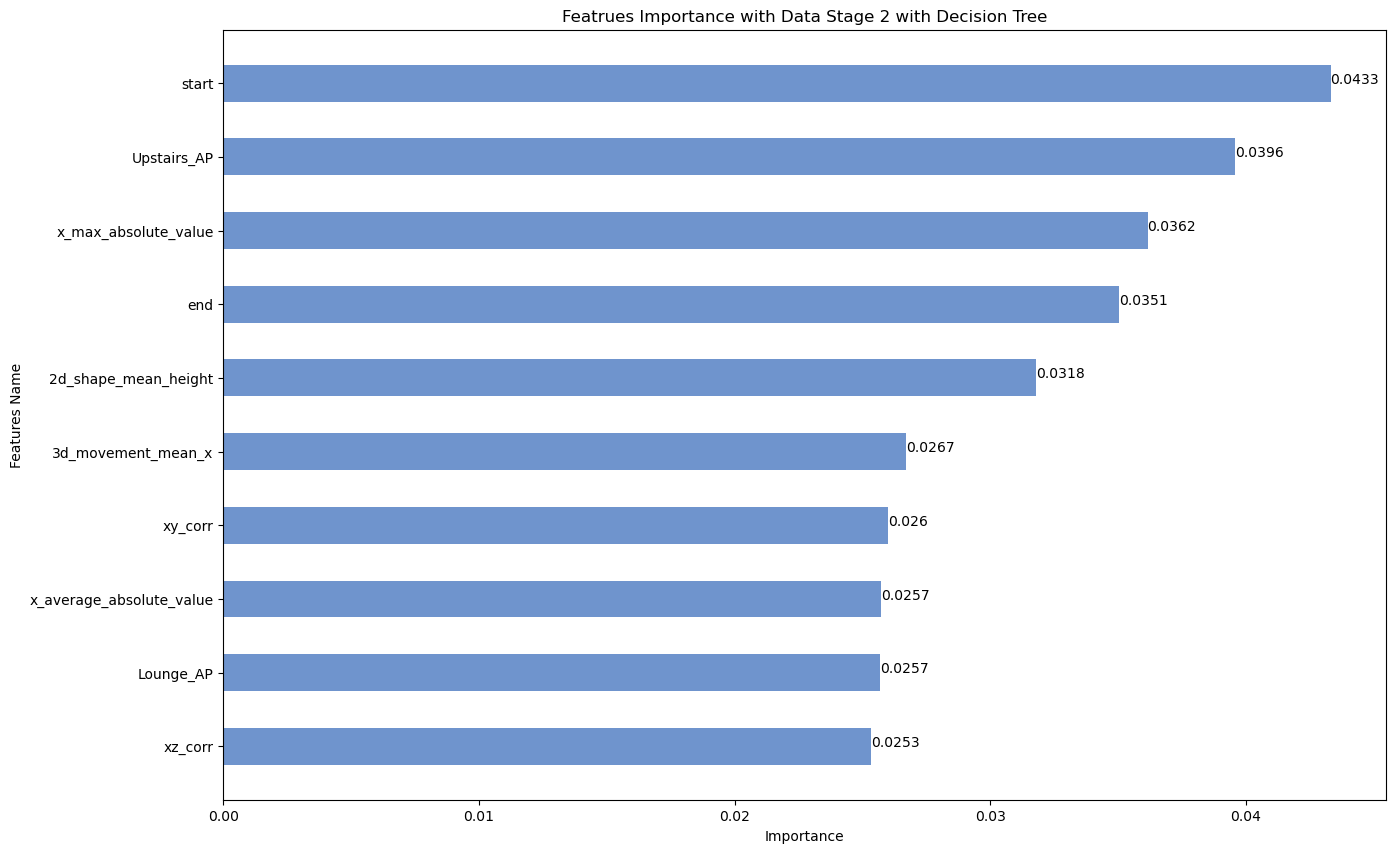

In [9]:
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.barh(importance_df2['features'].tail(10), importance_df2['mean'].tail(10), color='#6f94cd', height=0.5)
ax1.set_ylabel('Features Name')
ax1.set_xlabel('Importance')
ax1.set_title('Featrues Importance with Data Stage 2 with Decision Tree')

for index, value in enumerate(importance_df2['mean'].tail(10)):
    ax1.text(value, index, str(round(value, ndigits=4)))

plt.show()

In [10]:
datasets = []
for i in range(1, 11):
    df = pd.read_csv(f'../train/{i:05d}/train_stage3.csv')
    df['target_vector'] = df['target_vector'].apply(ast.literal_eval) 
    
    def set_max_to_one(target_list):
        max_value = max(target_list)
        return [1 if value == max_value else 0 for value in target_list]
    
    target_df = pd.DataFrame(df['target_vector'].apply(set_max_to_one).tolist(), index=df.index)
    features_df = df.drop(columns=['target_vector'])
    datasets.append((features_df, target_df))

kf = KFold(n_splits=5, shuffle=True, random_state=42)

brier_scores = []
model_importance3 = []

for train_index, test_index in kf.split(datasets):
    X_train = pd.concat([datasets[i][0] for i in train_index], ignore_index=True)
    y_train = pd.concat([datasets[i][1] for i in train_index], ignore_index=True)
    
    X_test = pd.concat([datasets[i][0] for i in test_index], ignore_index=True)
    y_test = pd.concat([datasets[i][1] for i in test_index], ignore_index=True)
    

    model = make_pipeline(
        SimpleImputer(strategy='constant', fill_value=0),  
        MultiOutputClassifier(DecisionTreeClassifier())
    )
    
    model.fit(X_train, y_train)

    model_classifier = model.named_steps['multioutputclassifier']

    model_importance3.append(estimator.feature_importances_ for estimator in model_classifier.estimators_)
    
   
    y_prob = model.predict_proba(X_test)
    
    brier_score = np.mean([brier_score_loss(y_test.iloc[:, c], y_prob[c][:, 1], pos_label=1) for c in range(y_test.shape[1])])
    brier_scores.append(brier_score)
    print(brier_score)


print(f'Stage 3 Average score across all folds: {np.mean(brier_scores)}')

0.07436526255049047
0.0713876511775939
0.06196983977379831
0.061892387649037
0.06171926364234057
Stage 3 Average score across all folds: 0.06626688095865205


In [11]:
importance_df3 = pd.DataFrame()

features3 = pd.read_csv('../train/00001/train_stage3.csv').drop('target_vector', axis=1).columns

importance_df3['features'] = features3

counter = 1
for generator in model_importance3:
    for value in generator:
        col_name = 'value' + str(counter)
        importance_df3[col_name] = value
        counter += 1

importance_df3['mean'] = importance_df3.drop('features', axis=1).mean(axis=1)
importance_df3 = importance_df3.sort_values(by='mean')
importance_df3

C:\Users\jhao3\AppData\Local\Temp\ipykernel_6392\3256935219.py:11: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  importance_df3[col_name] = value
C:\Users\jhao3\AppData\Local\Temp\ipykernel_6392\3256935219.py:14: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  importance_df3['mean'] = importance_df3.drop('features', axis=1).mean(axis=1)


,features,value1,value2,value3,value4,value5,value6,value7,value8,value9,...,value92,value93,value94,value95,value96,value97,value98,value99,value100,mean
19,2d_shape_std_width,0.000000,0.000000,0.000000,0.000000,0.003719,0.002133,0.000000,0.003023,0.001309,...,0.008158,0.000000,0.004218,0.000000,0.007896,0.000000,0.000000,0.017306,0.007911,0.005447
15,3d_movement_std_y,0.028550,0.001044,0.000000,0.029402,0.006206,0.005761,0.002786,0.000664,0.002846,...,0.010842,0.005156,0.000000,0.017104,0.018677,0.000000,0.022576,0.008064,0.006372,0.005589
9,2d_movement_std_x,0.000000,0.000000,0.002057,0.000000,0.007898,0.000853,0.002786,0.002846,0.000654,...,0.004776,0.007895,0.000000,0.016355,0.005068,0.007870,0.012527,0.000000,0.003367,0.006543
24,3d_shape_std_height,0.000000,0.001042,0.000000,0.000000,0.004140,0.009494,0.004118,0.000996,0.001265,...,0.033937,0.000000,0.020738,0.004291,0.018260,0.012932,0.001881,0.006490,0.005878,0.006739
23,3d_shape_std_width,0.000000,0.000000,0.000000,0.000000,0.013431,0.001693,0.002786,0.002132,0.001311,...,0.000000,0.000000,0.025771,0.010046,0.008407,0.026834,0.018059,0.014279,0.009677,0.006792
10,2d_movement_std_y,0.000000,0.023937,0.000000,0.000000,0.003966,0.002768,0.012815,0.001325,0.001721,...,0.008701,0.028312,0.009060,0.005406,0.013018,0.000000,0.016814,0.004535,0.009073,0.007383
14,3d_movement_std_x,0.000000,0.015346,0.000000,0.015916,0.033068,0.004531,0.012859,0.000000,0.002260,...,0.008090,0.019877,0.000000,0.005407,0.001264,0.008395,0.000000,0.010503,0.015710,0.007410
17,2d_shape_mean_width,0.000000,0.000000,0.000000,0.008953,0.002865,0.005816,0.000000,0.000000,0.038431,...,0.009106,0.000000,0.022113,0.000000,0.002633,0.027902,0.017540,0.003596,0.022445,0.007480
20,2d_shape_std_height,0.000000,0.000000,0.027091,0.000000,0.004054,0.005318,0.000000,0.002565,0.001684,...,0.013879,0.000000,0.000000,0.006272,0.033884,0.005167,0.004972,0.017258,0.009257,0.007572
22,3d_shape_mean_height,0.000000,0.000000,0.000000,0.055855,0.013247,0.018675,0.002897,0.000491,0.007776,...,0.004116,0.019243,0.010542,0.016652,0.008274,0.025375,0.004251,0.000000,0.013299,0.012841


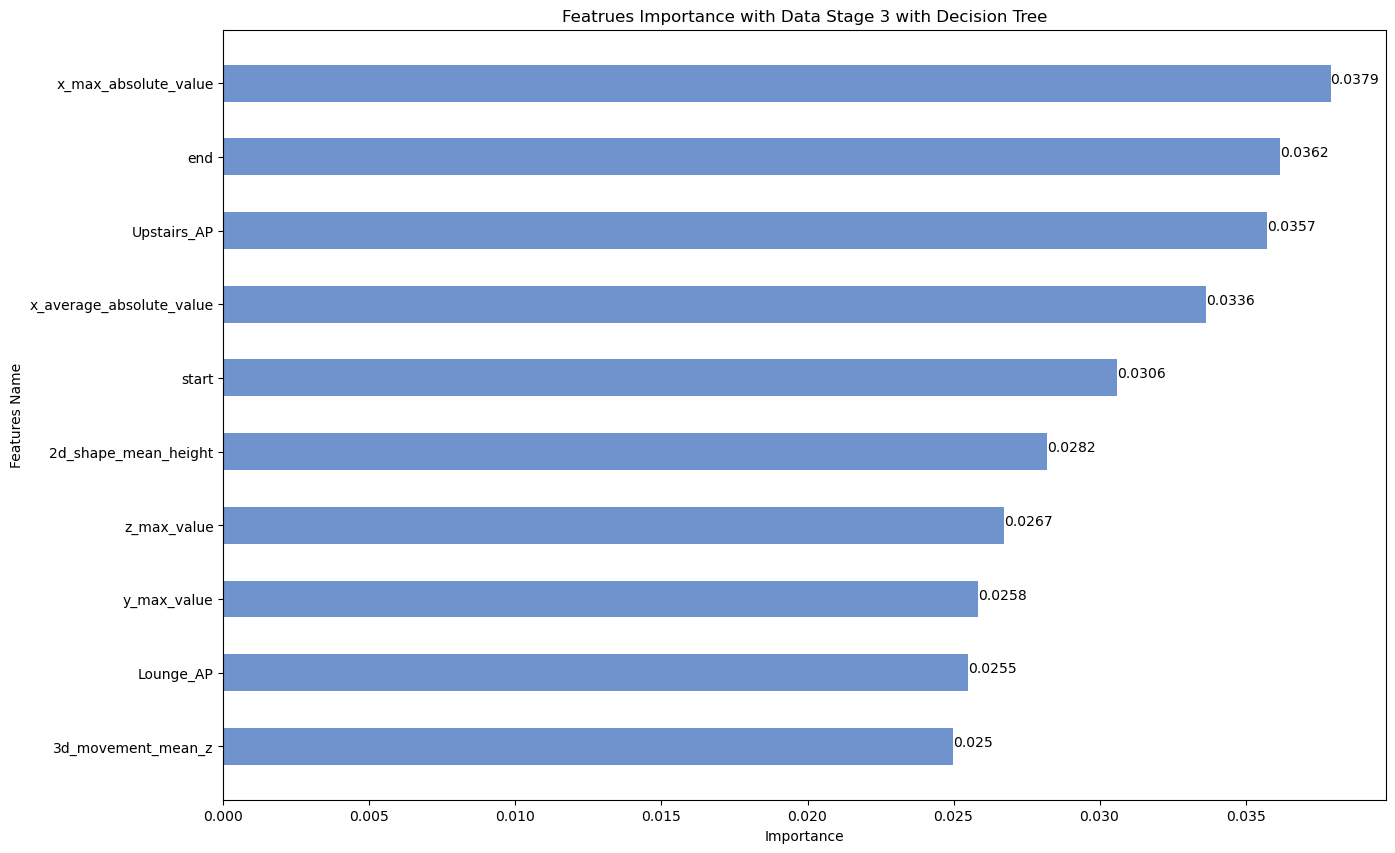

In [12]:
fig, ax1 = plt.subplots(figsize=(15,10))

ax1.barh(importance_df3['features'].tail(10), importance_df3['mean'].tail(10), color='#6f94cd', height=0.5)
ax1.set_ylabel('Features Name')
ax1.set_xlabel('Importance')
ax1.set_title('Featrues Importance with Data Stage 3 with Decision Tree')

for index, value in enumerate(importance_df3['mean'].tail(10)):
    ax1.text(value, index, str(round(value, ndigits=4)))

plt.show()